# Kinetic Component Analysis in Python
#### Python code is from Kinetic Component Analysis, Marcos López de Prado & Riccardo Rebonato - Journal of Investing (2016) and only changed slightly to allow for user input with regarding to the size of A (i.e. the number of degrees of the Taylor expansion).

In [24]:
# Install packages
import numpy as np
import math, sys
import matplotlib.pyplot as pp
from pykalman import KalmanFilter

In [25]:
def fitKCA(t,z,q=0.001,a=2):
    '''
    Inputs:
        t: Iterable with time indices
        z: Iterable with measurements
        q: Scalar that multiplies the seed states covariance
        a: Scalar that provides the degrees of the Taylor expansion
    Output:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''

    if a > 6 or a < 0:
        print("Input 'a' must be an integer in [0, 6] giving the degrees of the Taylor expansion.")
        sys.exit()

    # 1) Set up matrices A,H and a seed for Q
    h=(t[-1]-t[0])/t.shape[0]
    H = np.zeros(a) ; H[0] = 1.0
    A=np.zeros((a, a))
    for i in range(a):
        A[0:A.shape[1]-i, i:] += np.eye(a-i)/math.factorial(i)*h**i
    Q=q*np.eye(A.shape[0])

    # 2) Apply the filter
    kf=KalmanFilter(observation_matrices=H,transition_matrices=A,observation_covariance=1.0,transition_covariance=Q)

    # 3) EM estimates
    kf=kf.em(z)

    # 4) Smooth
    x_mean,x_covar=kf.smooth(z)
    
    # 6) Std series
    x_std=(x_covar[:,0,0]**0.5).reshape(-1,1)
    for i in range(1,x_covar.shape[1]):
        x_std_=x_covar[:,i,i]**0.5
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1)
    return x_mean,x_std,x_covar

In [26]:
def getPeriodic(periods,nobs,scale):
    t=np.linspace(0,np.pi*periods/2.0,nobs)
    s=np.sin(t)
    z=s+scale*np.random.randn(nobs)
    return t,s,z

In [27]:
def plotKCA(nobs = 300, periods = 10, scale = 0.5, q = 0.001, a = 2):
    plottext = ['position', 'velocity', 'acceleration', 'jerk', 'snap', 'crackle', 'pop']

    #2) Get Periodic noisy measurements
    t,s,z=getPeriodic(periods,nobs,scale=scale)

    #3) Fit KCA
    x_point,x_bands=fitKCA(t,z,q=q,a=a+1)[:2]

    #4) Plot KCA's point estimates
    color=['blue','green','red','pink','yellow','brown','purple']
    pp.plot(t,z,marker='x',linestyle='',label='measurements')
    pp.plot(t,s,color='black',label='signal')
    for i in range(x_point.shape[1]):
        pp.plot(t,x_point[:,i],marker='o',linestyle='-',label=plottext[i], color=color[i])
    pp.legend(loc='lower left',prop={'size':8})
    
    #5) Plot KCA's confidence intervals (2 std)
    for i in range(x_bands.shape[1]):
        pp.plot(t,x_point[:,i]-2*x_bands[:,i],linestyle='-',color=color[i])
        pp.plot(t,x_point[:,i]+2*x_bands[:,i],linestyle='-',color=color[i])
    pp.legend(loc='lower left',prop={'size':8})
    return

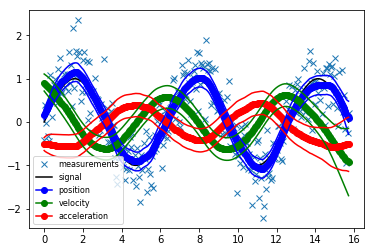

In [28]:
plotKCA(nobs=300,periods=10,scale=0.5,q=0.001,a=2)